# Bringup Experiments
In this tutorial notebook, we will review common pulse sequences that are used as first steps during the bring up of more complex pulse experiments:
- measure the resonance frequency of a qubit
- calibrate a $\pi$/2 pulse via Rabi spectroscopy
- measure the $T^*_2$ coherence time with a Ramsey sequence

You can use either Rigetti's Aspen M-3 or OQC's Lucy device to run this notebook.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

Let's first import some packages to construct pulse sequences and analyze results.

In [2]:
%matplotlib inline

from braket.aws import AwsDevice
from braket.pulse import PulseSequence, GaussianWaveform, ConstantWaveform
from braket.parametric import FreeParameter

## Imports for function fitting
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
from scipy.fft import fft, fftfreq

You will be able to switch from one device to the other by setting the `device_name` to `aspen` or `lucy`

In [3]:
device_name = "aspen"

We will use the following configuration to control the different parameters for our experiments across the available devices

In [4]:
experiment_configuration = {
    "aspen": {
        "device_arn": "arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3",
        "qubit": 4,
        "drive_frame": "q4_rf_frame",
        "readout_frame": "q4_ro_rx_frame",
        "spectroscopy_wf": GaussianWaveform(100e-9, 25e-9, 0.1, True),
        "rabi_wf": GaussianWaveform(FreeParameter("length"), FreeParameter("length") * 0.25, 0.2, True)
    },
    "lucy": {
        "device_arn": "arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy",
        "qubit": 0,
        "drive_frame": "q0_drive",
        "readout_frame": "r0_measure",
        "spectroscopy_wf": ConstantWaveform(25e-9, 0.03),
        "rabi_wf": ConstantWaveform(FreeParameter("length"), 0.07)
    }
}

Here we will first instantiate a device that will provide access to some properties such as frames

In [5]:
device = AwsDevice(experiment_configuration[device_name]["device_arn"])

With both devices, frames are predefined in the device capabilities and can be loaded with the Amazon Braket SDK. In this notebook, we will drive a single qubit, which only requires the frames:
- `q4_rf_frame` to drive the qubit and `q4_ro_rx_frame` to measure it. (Rigetti Aspen M-3)
- `q0_drive` to drive the qubit and `r0_measure` to measure it. (OQC Lucy) 


In [6]:
qubit = experiment_configuration[device_name]["qubit"]
drive_frame = device.frames[experiment_configuration[device_name]["drive_frame"]]
readout_frame = device.frames[experiment_configuration[device_name]["readout_frame"]]

## Qubit spectropscopy

Qubit spectroscopy is one of the first step to charaterize a qubit. While this information is already present in the frame properties, we will build a pulse sequence to estimate the transition frequency between the ground state and the first excited state.

For simplicity, we will use Gaussian or Constant waveforms as envelopes of the different pulses. The Gaussian waveforms are parametrized by their amplitude $A$ and the length $d$ of their pulse window. They are positioned at the center of the window ($d$/2) and their width (1/e) will be set to be a quarter of the window length ($d$/4). The Constant waveforms have a complex amplitude $iq$ . 

For qubit spectroscopy, while a prior knowledge of the systems helps choosing these parameters to increase the signal-to-noise ratio, it is not necessary to tune them precisely. 

With Aspen, we will use a pulse length of 100ns, the Gaussian has a width of 25ns and its amplitude is 0.1. With Lucy, We will use a pulse length of 25ns and an amplitude is 0.03. The amplitude unit should be considered as arbitrary, the maximum amplitude can be retrieved from the device capabilities, please see the documentation for more details.

In [7]:
waveform = experiment_configuration[device_name]["spectroscopy_wf"]



The pulse sequence below contains three instructions:
-	The first sets the frequency of the microwave signal to a chosen frequency among the range of frequency to probe
-	The second plays the waveform.
-	The third instruction is a readout instruction. Measurements are realized via the predefined function capture_v0() that executes a projective measurement of the qubit and returns the projected eigenstate.



In [8]:
frequency = FreeParameter("frequency")

pulse_sequence = ( 
    PulseSequence()
    .set_frequency(drive_frame, frequency)
    .play(drive_frame, waveform)
    .capture_v0(readout_frame)
)

We will sweep the frequency over a range that is centered around the expected transition frequency. For that, we use the FreeParameter object that we defined in the previous cell and create a new pulse sequence by binding the FreeParameter to each tested frequency.

We then run our batch of pulse sequence with `device.run_batch`, which returns a batch of quantum tasks.

In [9]:
span = 75e6
N_steps = 25
N_shots = 100
frequencies = np.linspace(drive_frame.frequency-span/2, drive_frame.frequency+span/2, N_steps)

qubit_spectroscopy_sequences = [pulse_sequence(frequency=frequency) for frequency in frequencies]
batch = device.run_batch(qubit_spectroscopy_sequences, shots=N_shots)

After executing this batch of tasks, we are ready to analyze the results. We will use a simple Gaussian fit function to extract the transition frequency.

In [10]:
def resonance_fit(x, A, A0, w, x0):
    return A0-A*np.exp(-(x-x0)**2/w**2)

The result format is the same as with circuits, which means that `result()` will return a task result object that includes a counter with the number of occurences for each eigenstate of the measurement basis. Since we have been using a batch, we can quickly construct the probability to measure the state $|0\rangle$. 

The data are then plotted and fitted with the previously defined fit function.

Expected resonance frequency: 4728.33 GHz
Measured resonance frequency: 4726.44 GHz


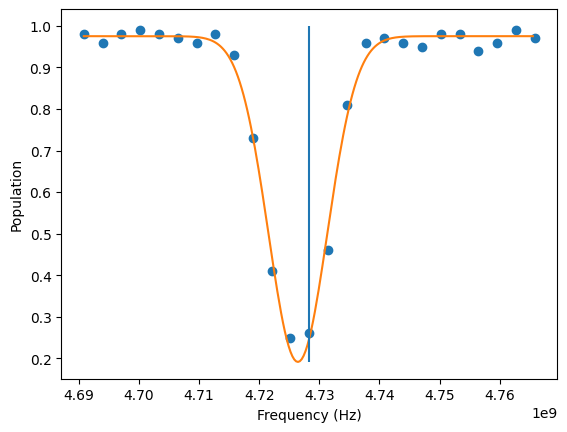

In [11]:
probability_of_zero = [result.measurement_counts['0']/N_shots for result in batch.results()]

x, y = frequencies, probability_of_zero

initial_guess=[1/2, 1, 10e6, drive_frame.frequency] # Amplitude, Offset, width, centerFrequency
optimal_params, _ = scipy.optimize.curve_fit(resonance_fit, x, y, p0=initial_guess)
x_fit = np.arange(x[0],x[-1], np.diff(x)[0]/10)
y_fit = resonance_fit(x_fit, *optimal_params)

plt.figure()
plt.plot(x,y, 'o')
plt.plot(x_fit,y_fit)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Population")
plt.vlines(drive_frame.frequency, min(y_fit), 1)
resonance_frequency = optimal_params[3]
print('Expected resonance frequency:', round(drive_frame.frequency*1e-6,2), 'GHz')
print('Measured resonance frequency:', round(resonance_frequency*1e-6,2), 'GHz')

## Calibrating $\pi$/2 pulses via Rabi spectroscopy 

Applying an electromagnetic field to a qubit leads to Rabi flopping, a cyclic behavior that is used to calibrate specific pulse parameters. Here, we will determine the optimal pulse length to realize a $\pi$/2 pulse, an elementary block used to build more complex pulse sequences, such as the Ramsey sequence. 

Below, we will reuse the previous pulse sequence. First, we will fix the driving frequency to the resonance frequency and replace the coarsely-chosen pulse length by a FreeParameter.

We also choose to increase the amplitude of the waveform to increase the rate of the expected oscillations.


In [12]:
waveform = experiment_configuration[device_name]["rabi_wf"]

rabi_sequence = ( 
    PulseSequence()
    .set_frequency(drive_frame, drive_frame.frequency)
    .play(drive_frame, waveform)
    .capture_v0(readout_frame)
)

As for qubit spectroscopy, we will sweep one parameter of our pulse sequence, here the length of the waveform.

We construct another batch of task with lengths ranging from 12ns to 200ns with a step of 12ns so all the sequences verify the 4-sample constraint (waveforms must have a length multiple of 4ns). 

In [13]:
start_length=12e-9
end_length=2e-7
lengths = np.arange(start_length, end_length, 12e-9)
N_shots = 100

pulse_sequences = [rabi_sequence(length=length) for length in lengths]

batch = device.run_batch(pulse_sequences, shots=N_shots)

To increase the chances of fitting success, we estimate some initial parameters values:
- initial signal mean is taken as the mean of the measurement data
- initial Rabi frequency is set as the position of the maximum value of the measurement data's FFT

In [14]:
def damped_oscillation_fit(x, A, A0, Tau, f, x0):
    return A*np.exp(-x/Tau)*np.cos(2*np.pi*(x-x0)*f)+A0

def estimate_fit_parameters(x, y):
    signal_mean = np.mean(y)
    idx_max=np.argmax(np.abs(fft(y-np.mean(y))))
    oscillation_frequency_estimate = fftfreq(len(x), np.diff(x)[0])[idx_max]

    return signal_mean, oscillation_frequency_estimate

The projected state after the qubit measurement reflects the oscillatory dynamics of the qubit that oscillates between the state $|0\rangle$ and the state $|1\rangle$. 
From the measurement data, one can extract the Rabi frequency as the flipping rate and compute the length of $\pi/2$ pulse.

Rabi frequency: 13.13  MHz
rx(pi/2) length:  17.62  ns
Redefined rx(pi/2) length:  16.0  ns


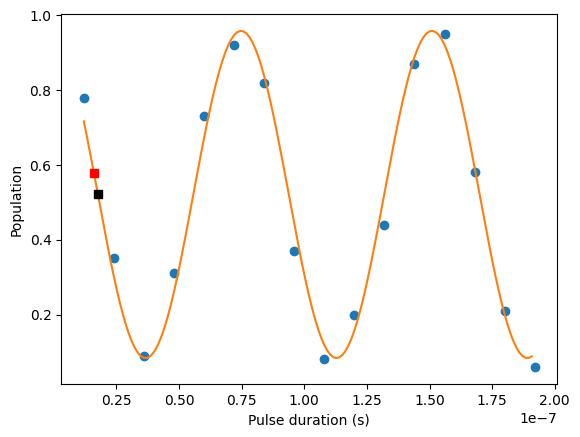

In [15]:
probability_of_zero = [result.measurement_counts['0']/N_shots for result in batch.results()]
x, y = lengths, probability_of_zero

signal_mean, oscillation_frequency_estimate = estimate_fit_parameters(x,y)

initial_guess=[1/2, signal_mean, 8e-6, oscillation_frequency_estimate, 0]
optimal_params, _ = scipy.optimize.curve_fit(damped_oscillation_fit, x, y, p0=initial_guess)
x_fit = np.arange(x[0],x[-1], np.diff(x)[0]/10)
y_fit = damped_oscillation_fit(x_fit, *optimal_params)

plt.plot(x,y, 'o')
plt.plot(x_fit,y_fit)
plt.xlabel("Pulse duration (s)")
plt.ylabel("Population")


rabi_frequency = optimal_params[3]
phase_offset = optimal_params[4]
x90_duration=(np.pi/2)/(2*np.pi*rabi_frequency)+phase_offset
plt.plot(x90_duration, damped_oscillation_fit(x90_duration, *optimal_params), 'ks')

print('Rabi frequency:', round(rabi_frequency*1e-6, 2), ' MHz')
print('rx(pi/2) length: ', round(x90_duration*1e9, 2), ' ns')

# Pulse duration must be a multiple of 4ns
x90_duration=x90_duration//4e-9*4e-9
plt.plot(x90_duration, damped_oscillation_fit(x90_duration, *optimal_params), 'rs')
print('Redefined rx(pi/2) length: ', round(x90_duration*1e9, 0), ' ns')

In [16]:
experiment_configuration["aspen"]["x90_wf"] = GaussianWaveform(x90_duration, x90_duration/4, 0.2, True)
experiment_configuration["lucy"]["x90_wf"] = ConstantWaveform(x90_duration, 0.07)

# Ramsey sequence - $T^*_2$ Measurement

In the following, we implement a Ramsey sequence that allows you to measure the coherence time of a qubit. The Ramsey sequence consists of two $\pi$/2 pulses separated by a varying gap. Starting from the $|0\rangle$ state, the first pulse creates an equal superposition of $|0\rangle$ and $|1\rangle$ which will decay back to a mixed state after a characteristic time called $T^*_2$. 

For better visualization, the carrier frequency is shifted away from the resonance frequency by some arbitraryily-chosen detuning which causes the frame of the driving to rotate with respect to the qubit frame. This results in oscillations at a rate equal to the detuning on top of the decoherence decay. 

In [17]:
detuning=250e3
x90 = experiment_configuration[device_name]["x90_wf"]

delay = FreeParameter("delay")
ramsey_spectroscopy = ( 
    PulseSequence()
    .set_frequency(drive_frame, drive_frame.frequency - detuning)
    .play(drive_frame, x90)
    .delay(drive_frame, delay)
    .play(drive_frame, x90)
    .capture_v0(readout_frame)
)

Once again, we will sweep a parameter of the sequence which is the time gap between the two $\pi$/2-pulses. 

In [18]:
start_delay=12e-9
end_delay=40000e-9
delays = np.arange(start_delay, end_delay, 512e-9)
N_shots=100

pulse_sequences = [ramsey_spectroscopy(delay=delay) for delay in delays]

batch = device.run_batch(pulse_sequences, shots=N_shots)

Plotting and fitting are not different from what we have seen with Rabi oscillations. We can now experimentally verify that the oscillations correspond to the frequency detuning of our pulses, and we can extract the coherence time $T^*_2$ of the qubit 

Detuning: 258.53  kHz
T2:  33.33  us


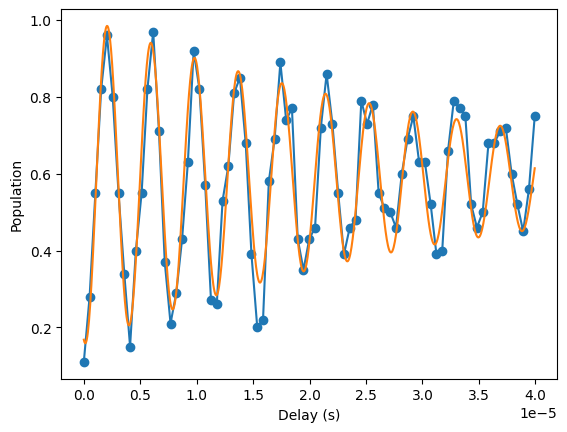

In [19]:
probability_of_zero = [result.measurement_counts['0']/N_shots for result in batch.results()]
x, y = delays, probability_of_zero
plt.plot(x,y, 'o-')

signal_mean, oscillation_frequency_estimate = estimate_fit_parameters(x,y)
initial_guess=[0.5, signal_mean, 2e-5, oscillation_frequency_estimate, 0]

optimal_params, _ = scipy.optimize.curve_fit(damped_oscillation_fit, x, y, p0=initial_guess)
x_fit = np.arange(x[0],x[-1], np.diff(x)[0]/10)
y_fit = damped_oscillation_fit(x_fit, *optimal_params)
plt.plot(x_fit,y_fit)
plt.xlabel("Delay (s)")
plt.ylabel("Population")
print('Detuning:', round(optimal_params[3]*1e-3, 2), ' kHz')
print('T2: ', round(np.abs(optimal_params[2])*1e6, 2), ' us')

In [20]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Task Summary
{'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3': {'shots': 12000, 'tasks': {'COMPLETED': 120}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 40.200 USD
